# **Transverse Field Ising Model**

Ising Model is a theoretical model to describe ferromagnetism in solids. It simplifies the complex properties of solids by assuming only nearest neighbor interaction between lattice sites and allowing only two opposite pointing orientations of each lattice site’s magnetic moment. Physically it's the opposite of an Ideal gas, as the particles are fixed but can interact compared to non-interacting moving particles in the Ideal gas. For details, see [Ising model](https://www.thphys.uni-heidelberg.de/~wolschin/statsem20_3s.pdf).

From a Computer Science perspective, NP-hard problems, including all of Karp's 21 NP-complete problems can be mapped to the Ising model with a polynomial overhead. Thus, any NP-hard problem can be reduced to finding the ground state of the Ising model. For further reference, look at [Ising formulations of NP-Complete problems](https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2014.00005/full).

Over time, Ising models have been applied to various other fields such as *Machine Learning (Hopfield networks)*, *Biology (Protein folding)*, and *Physics (Quantum phase transitions)*. The **Transverse Field Ising Model (TFIM)** is a quantum version of the Ising model, where spins are replaced by qubits and the interaction between spins is modified by a transverse magnetic field. This model is used to study quantum phase transitions and has applications in Quantum Computing and Condensed Matter Physics.


The Hamiltonian of the Transverse Field Ising Model is given by:

$$H = -J\sum_{i=1}^{N-1} Z_i Z_{i+1} - h\sum_{i=1}^N X_i$$

- *$Z$:* The Pauli $\sigma_z$ matrix (for spin measurement)
- *$X$:* The Pauli $\sigma_x$ matrix (for transverse field)
- *Ferromagnetic coupling ($J$)*: Favors alignment of neighboring spins along Z.  
- *Transverse field ($h$)*: Induces quantum fluctuations, polarizing spins along X.  

### **Ground States and Symmetry**

#### J >> h (Ferromagnetic Phase): 
When J is much larger than h, the spins tend to align along the Z-axis, leading to magnetization in the Z direction (ferromagnetic phase). Thus, the two degenerate ground states are:
$$
|\psi^{0+}\rangle = \otimes_{n=1}^N | \uparrow \rangle_n, \quad |\psi^{0-}\rangle = \otimes_{n=1}^N | \downarrow \rangle_n
$$  
These exhibit non-zero magnetization $M =\pm N$, where $N$ is the number of spins. The $\mathbf{Z}_2$ symmetry is broken, and the system has two degenerate ground states.


#### h >> J (Paramagnetic Phase): 
When h is much larger than J, the spins are polarized along the X-axis, leading to disordered state. 
Here Magnetization M = 0 and $\mathbf{Z}_2$ symmetry is preserved. The unique symmetric ground state is:
$$
|\psi^{0\to}\rangle = \bigotimes_{n=1}^N \frac{1}{\sqrt{2}} \left( | \uparrow \rangle_n + | \downarrow \rangle_n \right) = \otimes_{n=1}^N | \rightarrow \rangle_n
$$

The $\mathbb{Z}_2$ symmetry corresponds to a *global spin-flip* operation:
$ G = \otimes_i \sigma_i^x, $
which satisfies $G^2 = 1$, forming the cyclic group $\mathbb{Z}_2$.

Interaction term $\sigma_i^z \sigma_j^z$:
  $\quad G (\sigma_i^z \sigma_j^z) G^{-1} = \sigma_i^z \sigma_j^z \quad (\text{invariant}).$

Transverse field term $\sigma_i^x$:
  $\quad G (\sigma_i^x) G^{-1} = \sigma_i^x \quad (\text{invariant}).$

The Hamiltonian $H$ is invariant under $G$, confirming $\mathbb{Z}_2$ symmetry.

*The goal of this tutorial will be implementing Transverse Field Ising Models using QURI-Parts. We will approximate the ground state energy, wavefunction of the TFIM Hamiltonian using VQE and further improving it using QSCI. Finally we will calculate the correlation length and show divergence at the critical point which are relevant to Condensed Matter Physicist.*

### Setting up the QubitHamiltonian in QURI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence

from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

In [2]:
# Parameters
n_qubits = 6        # Number of spins/qubits
J = 1.0             # Interaction strength
h = 1.0            # Transverse field strength

def construct_TFIM_hamiltonian(J, h):
    hamiltonian = Operator()

    # Add Ising interaction terms (-J Σ Z_i Z_{i+1}) (Assuming periodic boundary conditions)
    for i in range(n_qubits-1):
        pauli_index = pauli_label('X'+str(i)+' X'+str(i+1))
        hamiltonian.add_term(pauli_index, -J)

    # Add transverse field terms (-h Σ X_i)
    for i in range(n_qubits):
        pauli_index = pauli_label('Z'+str(i))
        hamiltonian.add_term(pauli_index, -h)

    return hamiltonian

hamiltonian = construct_TFIM_hamiltonian(J, h)

Since *n_qubits* is small, we can find the smallest eigenvalue (ground energy state) of the Hamiltonian matrix directly. This is only done for benchmarking. For relistic physical systems involving large *n_qubits*, this computation is not feasible and we have to rely on Quantum Computing methods to find the approximate ground state.

In [3]:
## Ground eigenvalue and eigenvector computation using numpy (Will be later used for benchmarking)
vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

EXACT_GS_ENERGY = np.min(vals)
EXACT_GAP = vals[np.argsort(vals)][:2] @ [-1, 1]

print("E_0:", EXACT_GS_ENERGY)
print("Delta (E_1 - E_0)):", EXACT_GAP)

E_0: -7.296229810558756
Delta (E_1 - E_0)): 0.4821467210213024


### Statistical Phase Estimation (SPE):

[paper](https://arxiv.org/abs/2409.07749)

In [8]:
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.simulator import evaluate_state_to_vector


trial_state = quantum_state(n_qubits, bits=0) 
gs_overlap = np.abs(evaluate_state_to_vector(trial_state).vector @ vecs[:, 0])**2
print(f"Overlap between the chosen state and the exact grounds state vector: {gs_overlap: .1e}")

Overlap between the chosen state and the exact grounds state vector:  6.8e-01


In [9]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterControlledTimeEvolutionCircuitFactory
from quri_algo.core.estimator.time_evolution_estimator.trotter import TrotterTimeEvolutionHadamardTest
from quri_algo.problem import QubitHamiltonianInput

qubit_hamiltonian = QubitHamiltonianInput(n_qubits, hamiltonian)

# Setting the num_trotter steps to 30
trotter_concotrolled_time_evo_circuit_factory = (
    TrotterControlledTimeEvolutionCircuitFactory(qubit_hamiltonian, n_trotter=30)
)

# Time-evolution with t=1
c_time_evo = trotter_concotrolled_time_evo_circuit_factory(evolution_time=1)

sampler = create_qulacs_vector_sampler()
trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(qubit_hamiltonian, sampler, 50)

In [10]:
from quri_algo.algo.phase_estimation.spe import StepFunctionParam
from quri_algo.algo.phase_estimation.spe.lt22 import SingleSignalLT22GSEE

# Initializing the parameters for 
d_max = 1000
delta = 1e-4
n_sample = 10000
tau = 1 / 20
eta = 0.4

signal_param = StepFunctionParam(d=d_max, delta=delta, n_sample=n_sample)
lt22_algorithm = SingleSignalLT22GSEE(trotter_time_evolution_estimator, tau=tau)
spe_result = lt22_algorithm(trial_state, signal_param, eta)

lt22_gs_energy = spe_result.phase / tau
print(f"The obtained ground state energy is {lt22_gs_energy}")
print(f"The error is = {abs(lt22_gs_energy - np.min(vals))}")

The obtained ground state energy is -7.260219928402891
The error is = 0.03600988215586565


## VQE Optimization

As discussed previously, TFIM Hamiltonian is invariant under $\mathbf{Z}_2$ symmetry. The ansatz we choose for  the VQE optimzation also respects this symmetry. For further details on the ansatz, refer to this [paper]()

In [11]:
from quri_parts.algo.ansatz import Z2SymmetryPreservingReal
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

parametric_circuit = Z2SymmetryPreservingReal(n_qubits, 7)
# draw_circuit(parametric_circuit)

In [12]:
from quri_parts.core.state import quantum_state, apply_circuit

cb_state = quantum_state(n_qubits, bits=0)
parametric_state = apply_circuit(parametric_circuit, cb_state)

In [13]:
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.qulacs.estimator import create_qulacs_vector_concurrent_parametric_estimator, create_qulacs_vector_parametric_estimator
from quri_parts.algo.optimizer import Adam, OptimizerStatus

adam_optimizer = Adam()
estimator = create_qulacs_vector_parametric_estimator()
concurrent_parametric_estimator = create_qulacs_vector_concurrent_parametric_estimator()
gradient_estimator = create_parameter_shift_gradient_estimator(concurrent_parametric_estimator)

In [14]:
def h_cost_fn(hamiltonian):
    def cost_fn(param_values: Sequence[float]):
        estimate = estimator(hamiltonian, parametric_state, param_values)
        return estimate.value.real
    return cost_fn

def h_grad_fn(hamiltonian):
    def grad_fn(param_values: Sequence[float]) -> Sequence[float]:
        estimate = gradient_estimator(hamiltonian, parametric_state, param_values)
        return np.asarray([g.real for g in estimate.values])
    return grad_fn

In [15]:
def vqe(
    init_params: Sequence[float],
    cost_fn,
    grad_fn,
    optimizer,
    hamiltonian
):

    cost_fn = h_cost_fn(hamiltonian)
    grad_fn = h_grad_fn(hamiltonian)

    opt_state = optimizer.get_init_state(init_params)
    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)
        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break
    return opt_state

In [16]:
init_params = np.random.random(parametric_circuit.parameter_count)
vqe_state = vqe(init_params, h_cost_fn, h_grad_fn, adam_optimizer, hamiltonian)
print("Optimized value:", vqe_state.cost)
print("Optimized parameter:", vqe_state.params)
print("Iterations:", vqe_state.niter)

Optimizer converged
Optimized value: -7.290572048035439
Optimized parameter: [ 0.84210547  0.47630296  0.72138145  0.08867403  0.42050383  0.38267732
  0.26308393  0.2539943   0.73434537  0.69890491  0.68043424  0.59443225
  0.43669825 -0.11409208  0.99274025  0.43955635  0.92428532  1.12134875
 -0.24387333  0.48391352  0.83737877  0.78237401  0.26934266  0.12089239
 -0.03898091  0.07211114  1.47435145  1.71226973 -0.35714417 -0.26310673
  0.29395424  1.04856572  0.06303324  0.17537114  0.92165332  0.03408858
  0.24952452  0.42667829  1.15962726  0.64815756  0.94637548  0.64033568
 -0.11189446  0.23049688  0.28910377  0.54754249 -0.11291626  1.09501785
  0.81096834  1.02468288  0.87691451  0.24540542  0.33914711 -0.20934484
  0.38315606  0.99022627  1.17499058  1.23857066  0.91523247  0.14506946
  0.00339933  0.19914558 -0.4818045   0.21641909  0.37231599  0.55480196
  1.06836962  0.74356377  0.86127012  0.57459388]
Iterations: 56


### QSCI

In [17]:
BASIS_STATES = 5
TOTAL_SHOTS = 50000

In [18]:
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler
from quri_parts_qsci import qsci

sampler = create_qulacs_vector_concurrent_sampler()
bound_state = parametric_state.bind_parameters(vqe_state.params)
eigs, ground_state = qsci(
    hamiltonian, [bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
)

In [19]:
print("Ground state energy as per QSCI:", eigs[0])
print("Error (QSCI Ground energy - Actual Ground State energy):", np.abs(eigs[0] - np.min(vals)))

Ground state energy as per QSCI: -6.82842712474619
Error (QSCI Ground energy - Actual Ground State energy): 0.46780268581256657


### **Magnetization**

The magnetization of the system is the sum of magnetic moment per spin. Here by magnetization we mean the Longitudinal Magnetization along the Z-axis.

$$
M_z = \langle \sum_{n=1}^N \sigma_n^z \rangle
$$

In [22]:
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
qulacs_estimator = create_qulacs_vector_estimator()

magnetization_operator = Operator()
for i in range(n_qubits):
    pauli_index = pauli_label('Z'+str(i))
    magnetization_operator.add_term(pauli_index, 1)

def calculate_magnetization(quantum_state):
    return qulacs_estimator(magnetization_operator, quantum_state)
    

In [23]:
print("Magnetization for Ground State Obtained:", calculate_magnetization(bound_state).value)

Magnetization for Ground State Obtained: (4.580102278457078+0j)


## **Quantum Phase Transition**:

Quantum phase transition is defined as the phenomenon where a major re-structuring of the ground state of a Quantum mechanical system occurs as a parameter of the Hamiltonian of the system is varied.

In Transverse Field Ising Model between the limits, $h << J$ and $h >> J$, the nature of the ground state changes. When $J >> h$ there are two ground states, with opposite signs of magnetization. When $h >> J$ there is a single ground state with zero magnetization. The transverse Ising model is interesting because it exhibits a second order “quantum phase transition” at a critical value of $\frac{h}{J}$. Here, a doublet of degenerate ground states, each with nonzero spontaneous magnetization must merge to form a unique ground state with zero magnetization. The quantum phase transition is of “second order” because the ground state energy, as a function of the parameter which is being varied to find the phase transition, has a discontinuous second derivative.

### Correlation Length and Divergence at Critical point

The *Correlation length* of a Quantum many body system quantifies how spins at different lattice sites are correlated for the ground state. For the *Transverse Field Ising Model (TFIM)*, it is defined as:

$$
C(r) = \langle \sigma_i^z \sigma_{i+r}^z \rangle - \langle \sigma_i^z \rangle \langle \sigma_{i+r}^z \rangle,
$$

where $r = |i - j|$ is the distance between spins. The *correlation length* $\xi$ is the characteristic length scale over which these correlations decay.

In [24]:
def correlation_fun(quantum_state, r):
    pair_corr_operator = Operator()
    for i in range(n_qubits):
        if i+r >= n_qubits:
            break
        pauli_index = pauli_label('Z'+str(i)+' Z'+str(i+r))
        pair_corr_operator.add_term(pauli_index, 1)  

    shifted_corr_operator = Operator()
    for i in range(n_qubits):
            if i+r >= n_qubits:
                break
            pauli_index = pauli_label('Z'+str(r))
            shifted_corr_operator.add_term(pauli_index, 1)

    return (
        qulacs_estimator(pair_corr_operator, quantum_state).value - 
        qulacs_estimator(magnetization_operator, quantum_state).value * qulacs_estimator(shifted_corr_operator, quantum_state).value
    )

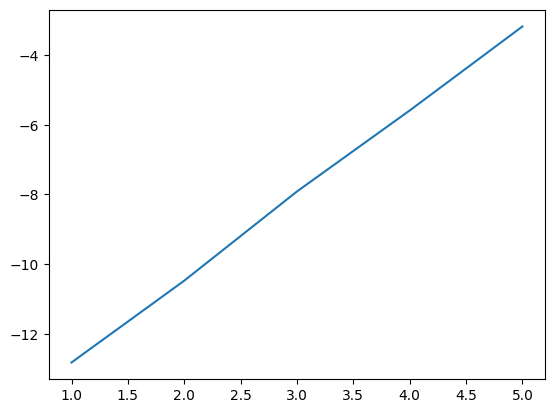

In [25]:
correlation = []
for i in range(1, n_qubits):
    correlation.append(correlation_fun(bound_state, i))

plt.plot(range(1, n_qubits), np.real(correlation))

#### Magntic Susceptibility

The *magnetic susceptibility* $\chi$ is a measure of how the magnetization of a system responds to an external magnetic field. It is defined as:
$$
\chi = \frac{\partial M}{\partial h}
$$
where $M$ is the magnetization and $h$ is the transverse field. The magnetic susceptibility diverges at the critical point, indicating a phase transition.

In [26]:
magnetization = []
h = np.linspace(0.8, 1.25, 10)

for i in h:
    hamiltonian = construct_TFIM_hamiltonian(J, i)
    
    adam_optimizer = Adam()
    init_params = np.random.random(parametric_circuit.parameter_count)
    vqe_state = vqe(init_params, h_cost_fn, h_grad_fn, adam_optimizer, hamiltonian)
    state = parametric_state.bind_parameters(vqe_state.params)

    magnetization.append(calculate_magnetization(state).value)

Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged


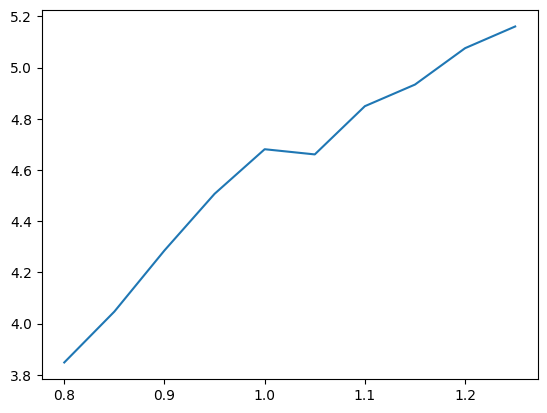

In [28]:
plt.plot(h, np.abs(magnetization))

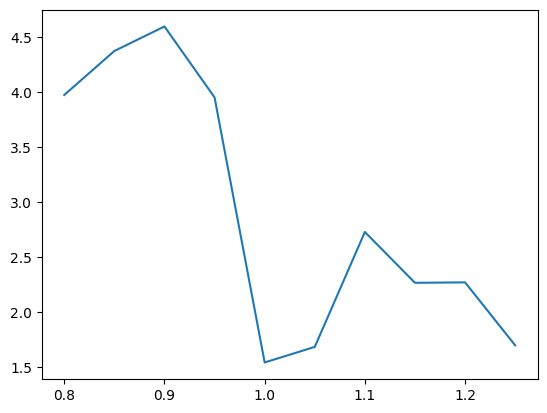

In [29]:

plt.plot(h, np.gradient(np.abs(magnetization), 0.05))

### **Entanglement Entropy**

For a bipartition into subsystems \( A \) and \( B \):
$$
S_A = -\text{Tr}(\rho_A \ln \rho_A), \quad \rho_A = \text{Tr}_B(|\psi\rangle\langle\psi|)
$$

- *Product state*: $S_A = 0$
- *Maximally entangled*: $S_A = \ln 2$ (Bell state)



### **Area Law vs. Volume Law**

|                          | Area Law                        | Volume Law                      |
|--------------------------|---------------------------------|---------------------------------|
| **Scaling**              | $S_A \propto \partial A$    | $S_A \propto \text{Vol}(A)$ |
| **TFIM Ground States**   | FM/PM phases                    | Never in ground states          |
| **Critical System**      | Logarithmic violation: $S_A \propto \ln L$ | |

### **Exact Solution via Jordan-Wigner Transformation**  
Map spins to fermions:  
$$
a_n = \sigma_n^- \prod_{m=1}^{n-1} \sigma_m^x, \quad a_n^\dagger = \sigma_n^+ \prod_{m=1}^{n-1} \sigma_m^x
$$  
**Hamiltonian in Fermionic Terms**:  
$$
H = J \sum_{n=1}^{N-1} (a_n^\dagger - a_n)(a_{n+1}^\dagger + a_{n+1}) + h \sum_{n=1}^N (1 - 2a_n^\dagger a_n)
$$  
Diagonalize using Fourier and Bogoliubov transformations. The energy gap:  
$$
\Delta = 2|J - h|
$$  
**Critical Point (h = J)**:  
$(\Delta \to 0)$, leading to gapless excitations.  

#### **Duality (Kramers-Wannier)**  
Under $(J \leftrightarrow h)$, the Hamiltonian retains its form, confirming criticality at \(h = J\).  

**Critical Exponents**:  
From the exact solution, exponents match the 2D classical Ising model:  
$$
\nu = 1, \quad \beta = \frac{1}{8}, \quad \gamma = \frac{7}{4}
$$  

## **Reference*:*

TFIM Tutorial: https://phas.ubc.ca/~seme/516/smtutorial2.pdf

## **Applications**

### **1. Quantum Annealing**  
**Mechanism**:  
The TIM Hamiltonian is used as a "driver" in adiabatic quantum computing:  
$$
H(t) = A(t) \sum_n \sigma_n^x + B(t) \sum_n \sigma_n^z \sigma_{n+1}^z
$$  
- Initial state $(t=0)$: Ground state of $(H_{\text{initial}} = -A(0) \sum \sigma_n^x)$ (paramagnetic phase).  
- Final state $(t=T)$: Ground state of $(H_{\text{final}} = -B(T) \sum \sigma_n^z \sigma_{n+1}^z)$ (encodes optimization problem).  

**Example**: Solving the MAX-CUT problem by mapping graph edges to \(J\) couplings.  

### **2. Material Realization ($CoNb_2O_6$)**  
- **Spin Chain Behavior**:  
  Neutron scattering experiments show dispersion relation:  
  $$
  \omega(k) \propto \sqrt{(J - h)^2 + 4Jh \sin^2(k/2)}
  $$  
  Matching TIM predictions.  
- **Critical Field**:  
  At $(h_c = J \approx 1.5 \, \text{T})$, magnetization vanishes, signaling the phase transition.  

### **3. Topological Edge States (Kitaev Chain)**  
**Mapping to Majorana Fermions**:  
Rewrite TIM fermions as Majorana operators:  
$$
\gamma_{2n-1} = a_n + a_n^\dagger, \quad \gamma_{2n} = i(a_n - a_n^\dagger)
$$  
**Edge Modes**:  
For \(J > h\), unpaired Majorana modes $(\gamma_1)$ and $(\gamma_{2N})$ appear at chain ends, leading to degeneracy:  
$$
|\psi_{\text{edge}}\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)
$$  
**Application**: Robust qubits for fault-tolerant quantum computing.  